---
## Python Package Imports
---

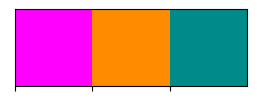

In [7]:
import  sys, os, glob, IPython
script_dir = "/".join(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[:-1]) + "/"
# script_dir = os.path.dirname(os.path.realpath(__file__))+"/"
plot_dir = script_dir+"plots/particleTracking/"

from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy as sp
import pandas as pd

import uproot

import seaborn as sns
sns.set_palette("colorblind")

protonColor = "magenta"
alphaColor = "darkorange"
He3Color = "darkcyan"

# Show the color palette
sns.palplot([protonColor, alphaColor, He3Color])
plt.show()


---
## ROOT File(s) Read-In
---

In [2]:
# Define the path to your ROOT files
rootfile_dir = script_dir+"root_particleTracking"
file_paths = glob.glob(rootfile_dir + "/*/*.root")

print("Number of ROOT Files: ", len(file_paths))
print("ROOT Directory: ", rootfile_dir)
# print("ROOT Files: ", file_paths)

# Initialize dictionaries
filedata = {}

# Generate Collection of ROOT Files and Convert to Dictionaries
i = 0
for file in file_paths:
    i += 1
    try:
        print("\t File: ", i, " ", file)
        # Open the ROOT file
        rootfile = uproot.open(file)
        rootfile_keys = rootfile.keys()

        # Particle Data TTree
        TTree = rootfile[rootfile_keys[0]]
        iTTreeArrays = TTree.arrays(library="np")  # makes a dict of arrays

        # for key in ipos:
        #     print(key)
        #     print(ipos[key])
        #     print(len(ipos[key]))
        #     print()

        # Consolidate Data
        for key in iTTreeArrays:
            if key in filedata:
                filedata[key] = np.append(filedata[key], iTTreeArrays[key])
            else:
                filedata[key] = iTTreeArrays[key]

        # Close the ROOT file
        rootfile.close()
    except:
        print("Error in File: ", i, " ", file)
        continue

##################################################
# "data" Summary

particles_per_run = 1e4
nRuns = 10
initial_particle_count = particles_per_run * nRuns

keys = list(filedata.keys())
nKeys = len(filedata.keys())
nDataPoints = len(filedata[keys[0]])
nLayers = max(filedata["fLayerNumber"])+1

print()
print("Keys: ", keys)
print("Number of Keys: ", nKeys)
print("Number of Data Points: ", nDataPoints)
print("Number of Layers: ", nLayers)
print("Number of Beam Particles: ", initial_particle_count, " (seen at each layer)")
print()

Number of ROOT Files:  10
ROOT Directory:  /Users/ayelland/Research/Projects/Helium34/ROOTPythonAnalysis/root_particleTracking
	 File:  1   /Users/ayelland/Research/Projects/Helium34/ROOTPythonAnalysis/root_particleTracking/12112023_0622_run1e4proton/12112023_0622_run1e4proton.root
	 File:  2   /Users/ayelland/Research/Projects/Helium34/ROOTPythonAnalysis/root_particleTracking/12112023_0647_run1e4proton/12112023_0647_run1e4proton.root
	 File:  3   /Users/ayelland/Research/Projects/Helium34/ROOTPythonAnalysis/root_particleTracking/12112023_0514_run1e4proton/12112023_0514_run1e4proton.root
	 File:  4   /Users/ayelland/Research/Projects/Helium34/ROOTPythonAnalysis/root_particleTracking/12112023_0553_run1e4proton/12112023_0553_run1e4proton.root
	 File:  5   /Users/ayelland/Research/Projects/Helium34/ROOTPythonAnalysis/root_particleTracking/12112023_0425_run1e4proton/12112023_0425_run1e4proton.root
	 File:  6   /Users/ayelland/Research/Projects/Helium34/ROOTPythonAnalysis/root_particleTrack

---
## Breaking Apart Data from Datafile
---

In [3]:
##################################################
# Sorting Data by Particle Name, Z Position, and Layer Number

data = {}

for particle_name in set(filedata["fParticleName"]):
    name_mask = (filedata["fParticleName"] == particle_name)

    # Use numpy.lexsort to perform two-level sorting
    sorting_indices = np.lexsort((filedata["fLayerNumber"][name_mask], filedata["fPosZ"][name_mask]))

    data[particle_name] = {
        "type": filedata["fParticleType"][name_mask][sorting_indices],
        "eventID": filedata["fEventID"][name_mask][sorting_indices],
        "layerNumber": filedata["fLayerNumber"][name_mask][sorting_indices],
        "posX": filedata["fPosX"][name_mask][sorting_indices] / 1e6,  # mm -> km
        "posY": filedata["fPosY"][name_mask][sorting_indices] / 1e6,  # mm -> km
        "posZ": (filedata["fPosZ"][name_mask][sorting_indices] / 1e6) + 505, # mm -> km
        "momX": filedata["fMomX"][name_mask][sorting_indices],  # (MeV*ns)/mm -> (MeV*s)/km
        "momY": filedata["fMomY"][name_mask][sorting_indices],  # (MeV*ns)/mm -> (MeV*s)/km
        "momZ": filedata["fMomZ"][name_mask][sorting_indices],  # (MeV*ns)/mm -> (MeV*s)/km
        "atomicNumber": filedata["fZ"][name_mask][sorting_indices],
        "massNumber": filedata["fA"][name_mask][sorting_indices],
        "charge": filedata["fQ"][name_mask][sorting_indices],
        "energy": filedata["fE"][name_mask][sorting_indices],  # MeV
        "edep": filedata["fEdep"][name_mask][sorting_indices],  # MeV
    }

print("Number of Particle Species: ", len(data.keys()))
print("Number of Data Points for each Particle Species:")
for key in data.keys():
    formatted_key = "{}".format(key).ljust(12)
    print("\t{} ::\t".format(formatted_key), len(data[key]["posX"]))


Number of Particle Species:  14
Number of Data Points for each Particle Species:
	alpha        ::	 2720
	pi0          ::	 190
	pi-          ::	 160
	triton       ::	 4080
	neutron      ::	 80
	e+           ::	 20
	e-           ::	 6452310
	He3          ::	 8670
	deuteron     ::	 27550
	pi+          ::	 110
	kaon0S       ::	 20
	Li6          ::	 10
	proton       ::	 99648010
	eta          ::	 20


In [4]:
def remove_beam_particles(data, particle_name, initial_particle_count):

    unique_layers = np.unique(data[particle_name]["layerNumber"])

    generated_data = dict()
    generated_data[particle_name] = dict()
    particles_per_layer = []
    generated_particles_per_layer = []

    for layer in unique_layers:

        layer_mask = (data[particle_name]["layerNumber"] == layer)
        origin_mask = ((data[particle_name]["posX"][layer_mask] == 0) & (data[particle_name]["posY"][layer_mask] == 0))

        # print("Layer", layer)
        # print("\t Number of Particles: ", len(data[particle_name]["posX"][layer_mask]))
        # print("\t Number of Particles at x,y = 0,0: ", len(data[particle_name]["posX"][layer_mask][origin_mask]))

        if len(data[particle_name]["posX"][layer_mask][origin_mask]) != initial_particle_count:

            # Calculate the number of missing particles from the initial particle count
            missing_particles = initial_particle_count - len(data[particle_name]["posX"][layer_mask][origin_mask])

            # Calculate distances from the origin for all particles in the layer
            distances = np.sqrt(data[particle_name]["posX"][layer_mask]**2 + data[particle_name]["posY"][layer_mask]**2)

            # Sort particles based on distance
            sorted_indices = np.argsort(distances)
            near_origin_indices = []
            nMissing = 0
            for i in range(len(sorted_indices)):
                if (nMissing < missing_particles) & (distances[sorted_indices[i]] != 0):
                    near_origin_indices.append(sorted_indices[i])
                    nMissing += 1

            # Update the origin_mask with the new particles
            origin_mask[near_origin_indices] = True

            # print("\t\t Missing Particles: ", missing_particles)
            # print("\t\t Indices of Missing Particles: ", near_origin_indices)
            # print("\t Number of Particles at/near x,y = 0,0: ", len(data[particle_name]["posX"][layer_mask][origin_mask]))
        
        # Remove the beam particles from the data
        for key in data[particle_name].keys():
            if key in generated_data[particle_name].keys():
                generated_data[particle_name][key] = np.append(generated_data[particle_name][key], data[particle_name][key][layer_mask][~origin_mask])
            else:
                generated_data[particle_name][key] = data[particle_name][key][layer_mask][~origin_mask]

    ##################################################
    # "generated_data" Summary

    # print("Number of Keys: ", len(generated_data[particle_name].keys()))
    # print("Number of Data Points: ", len(generated_data[particle_name]["posX"]))
    # print("Keys: ", generated_data[particle_name].keys())
       
    return generated_data


In [ ]:
##################################################
# Testing the Data Cuts
##################################################

##################################################
# Data before removing the Beam Particles

beam_particle = "proton"

unique_layers = np.unique(data[beam_particle]["layerNumber"])

particles_per_layer = []
generated_particles_per_layer = []
for layer in unique_layers:
    layer_mask = (data[beam_particle]["layerNumber"] == layer)
    layer_particle_count = len(data[beam_particle]["posX"][layer_mask])
    particles_per_layer.append(layer_particle_count)
    generated_particles_per_layer.append(layer_particle_count - initial_particle_count)

print("Before removing the Beam Particles:")
print("\tNumber of Layers with Signals  : ", len(unique_layers))
print("\tParticles per Layer            : ", particles_per_layer)
print("\tParticles per Layer (generated): ", generated_particles_per_layer)
print()

##################################################
# Data after removing the Beam Particles

gen_data_protons = remove_beam_particles(data, beam_particle, initial_particle_count)

unique_layers = np.unique(gen_data_protons[beam_particle]["layerNumber"])

particles_per_layer_wout_beam = []
for layer in unique_layers:
        layer_mask = (gen_data_protons[beam_particle]["layerNumber"] == layer)
        layer_particle_count = len(gen_data_protons[beam_particle]["posX"][layer_mask])
        particles_per_layer_wout_beam.append(layer_particle_count)

print("After removing the Beam Particles:")
print("\tNumber of Layers with Signals  : ", len(unique_layers))
print("\tParticles per Layer            : ", particles_per_layer_wout_beam)
print()



In [5]:
##################################################
# Create a new dictionary with the beam particles removed

beam_particle = "proton"

gen_data = dict()
for particle_name in data.keys():
    if particle_name != beam_particle:
        gen_data[particle_name] = data[particle_name]
    else:
        gen_data.update(remove_beam_particles(data, particle_name, initial_particle_count))
        
##################################################
# gen_data Summary

print("Number of Particle Species: ", len(gen_data.keys()))
print("Particle Species: ", gen_data.keys())
print()
print("Number of Data Points for each Particle Species:")
for key in gen_data.keys():
    print("\t", key, ":: \t", len(gen_data[key]["posX"]))


Number of Particle Species:  14
Particle Species:  dict_keys(['alpha', 'pi0', 'pi-', 'triton', 'neutron', 'e+', 'e-', 'He3', 'deuteron', 'pi+', 'kaon0S', 'Li6', 'proton', 'eta'])

Number of Data Points for each Particle Species:
	 alpha :: 	 2720
	 pi0 :: 	 190
	 pi- :: 	 160
	 triton :: 	 4080
	 neutron :: 	 80
	 e+ :: 	 20
	 e- :: 	 6452310
	 He3 :: 	 8670
	 deuteron :: 	 27550
	 pi+ :: 	 110
	 kaon0S :: 	 20
	 Li6 :: 	 10
	 proton :: 	 283060
	 eta :: 	 20


In [6]:
##################################################
# Save the Python Dictionary to a JSON File
import json

# Convert NumPy arrays to lists before saving to JSON
def convert_numpy_arrays(item):
    if isinstance(item, np.ndarray):
        return item.tolist()
    elif isinstance(item, np.generic):
        return np.asscalar(item)
    return item

with open(script_dir+"sorted_data/particleTracking_100GeV_1e5p_genData.json", "w") as write_file:
    json.dump(gen_data, write_file, indent=4, default=convert_numpy_arrays)


---
## Plotting & Simulation Parameters
---

In [8]:
##################################################
# Simulation Parameters

# World Volume Half-Widths
xWorld = 50 # km
yWorld = 50 # km
zWorld = 505 # km

---
## Particle Track Trajectories
---

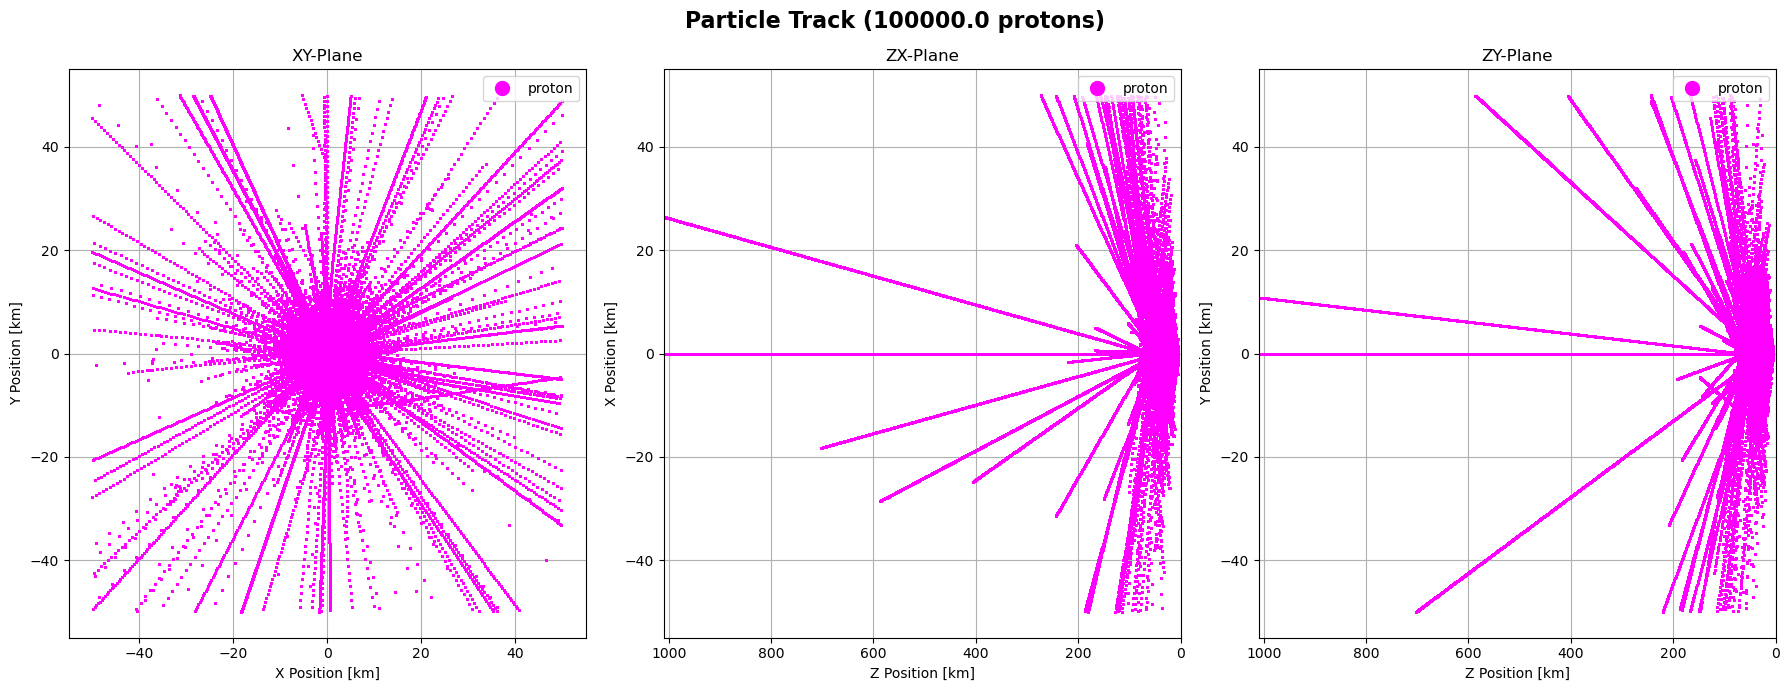

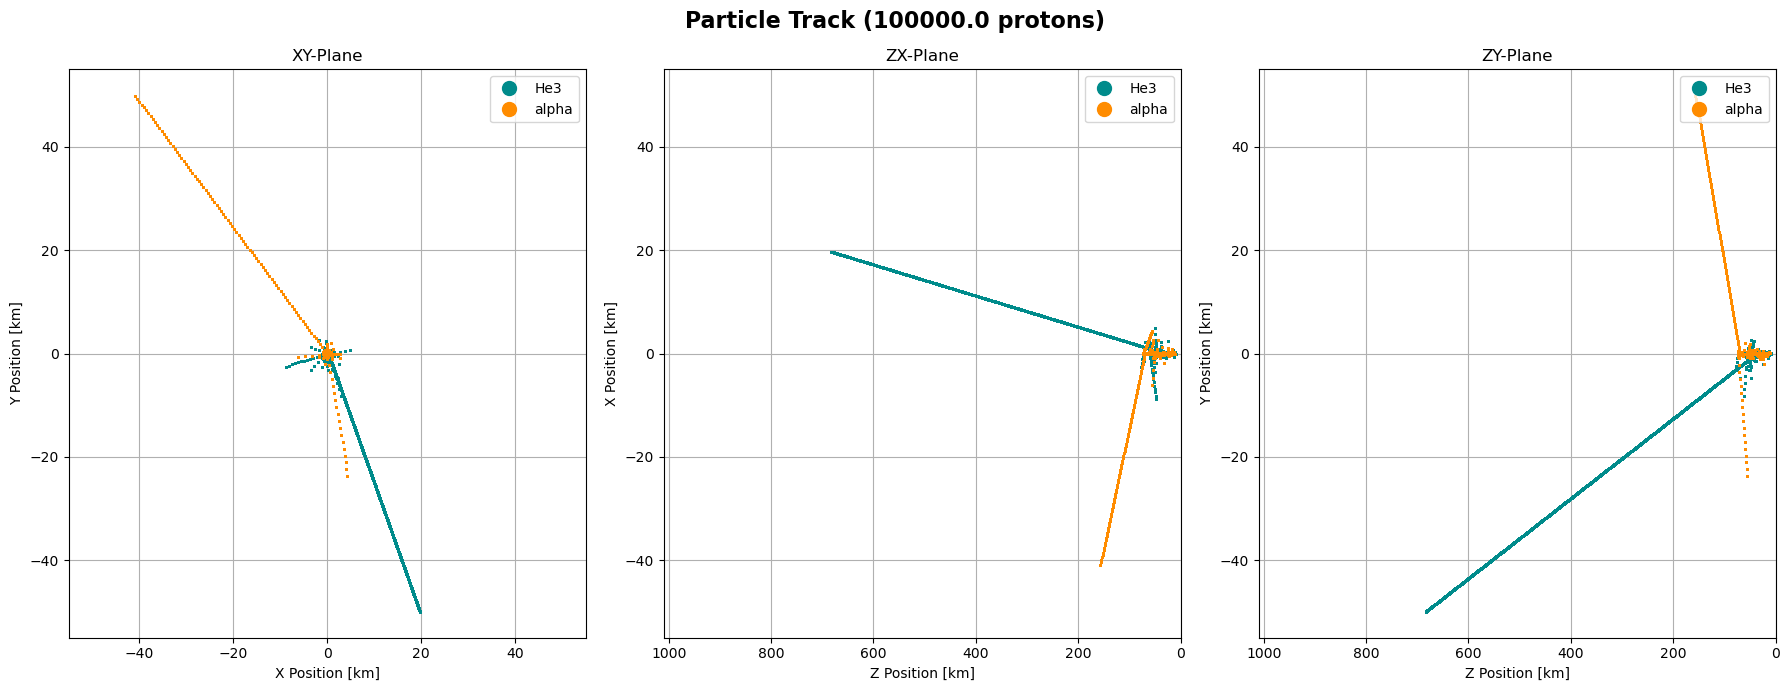

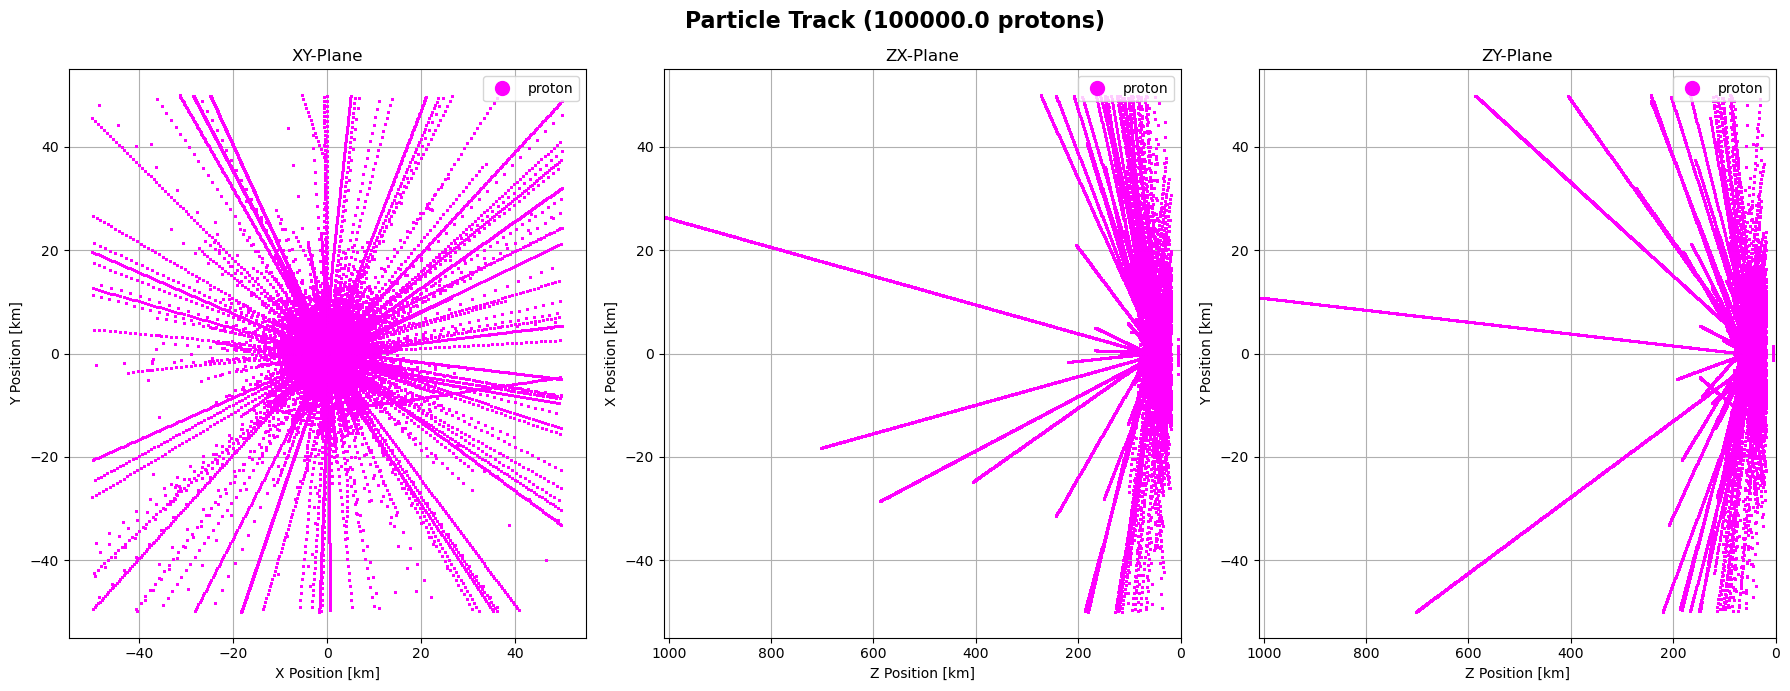

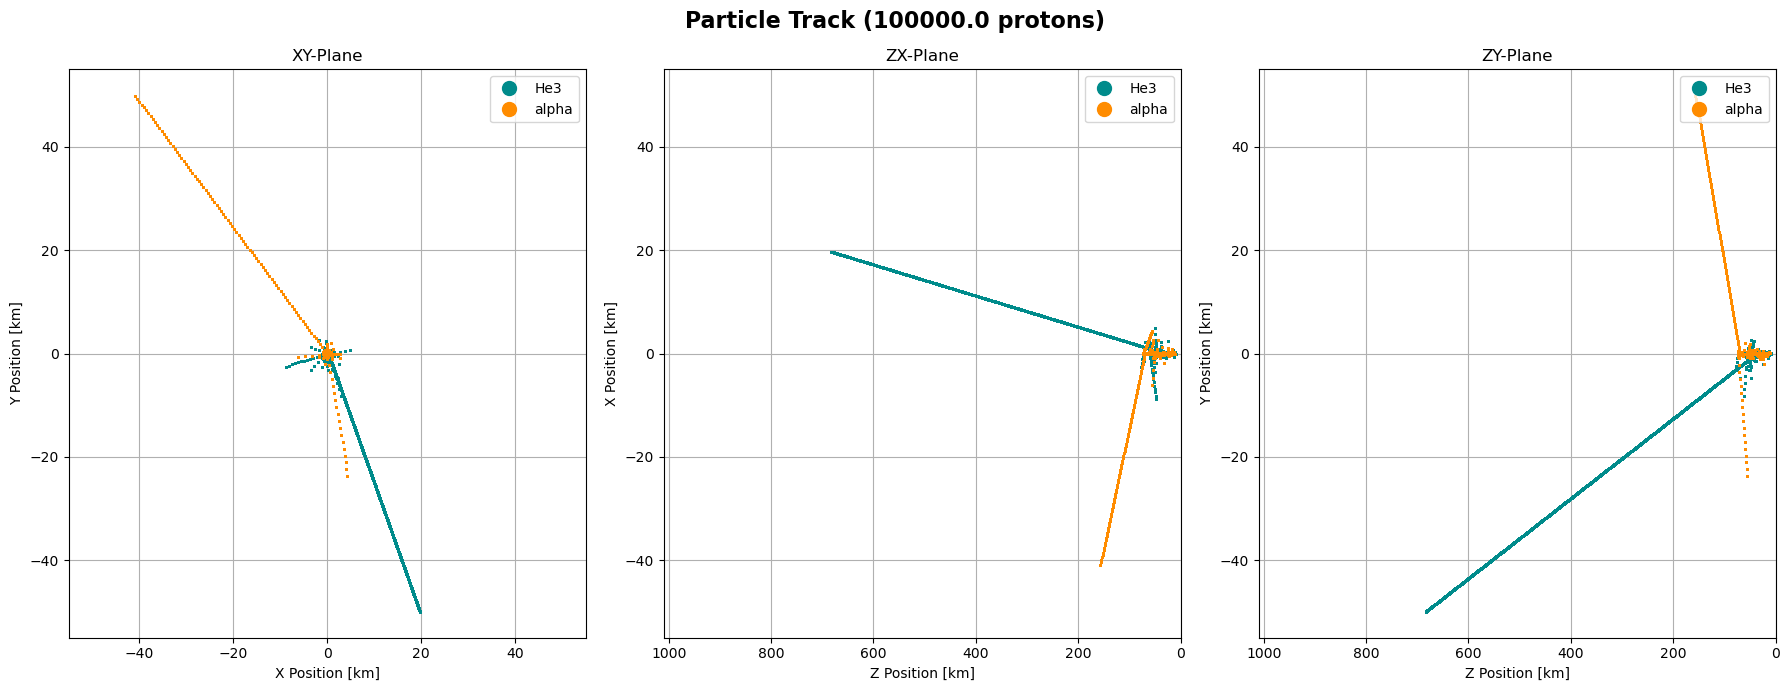

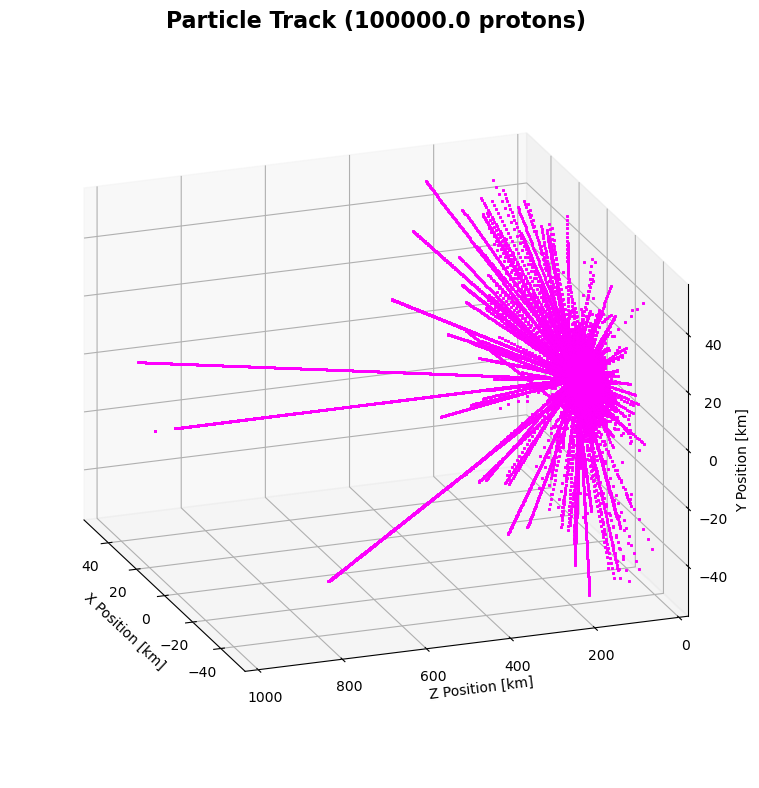

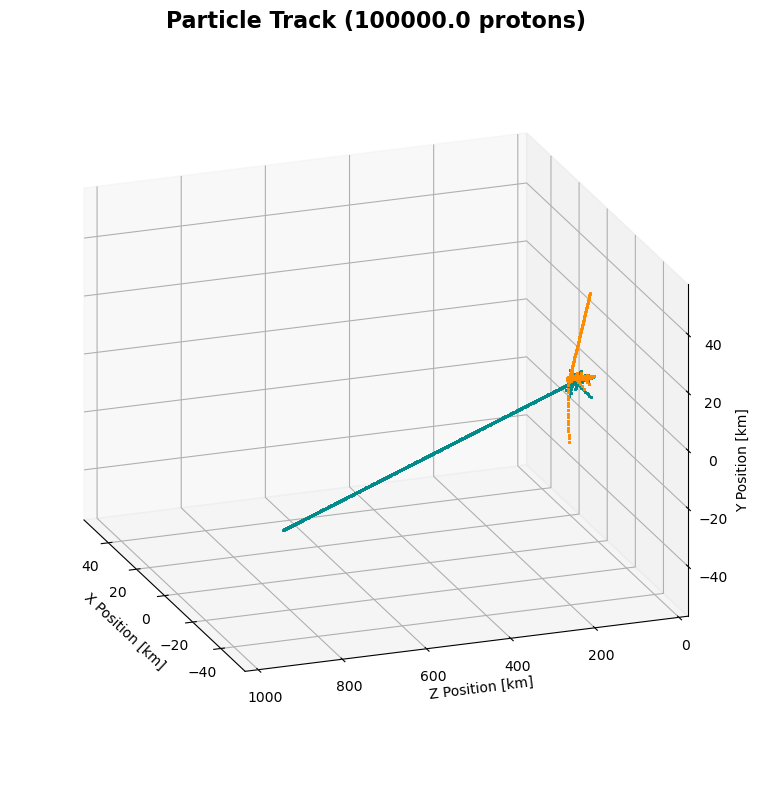

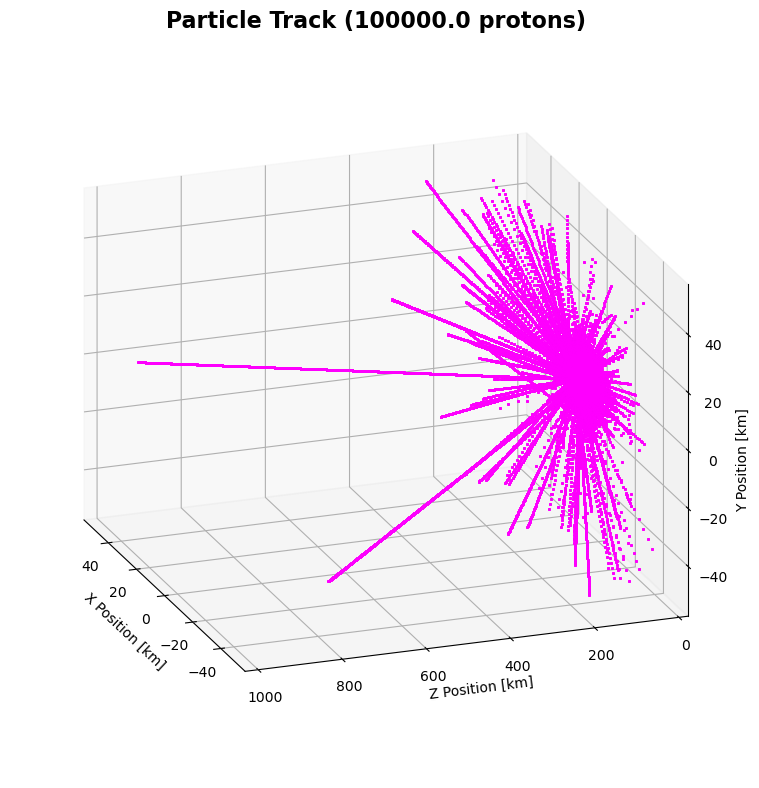

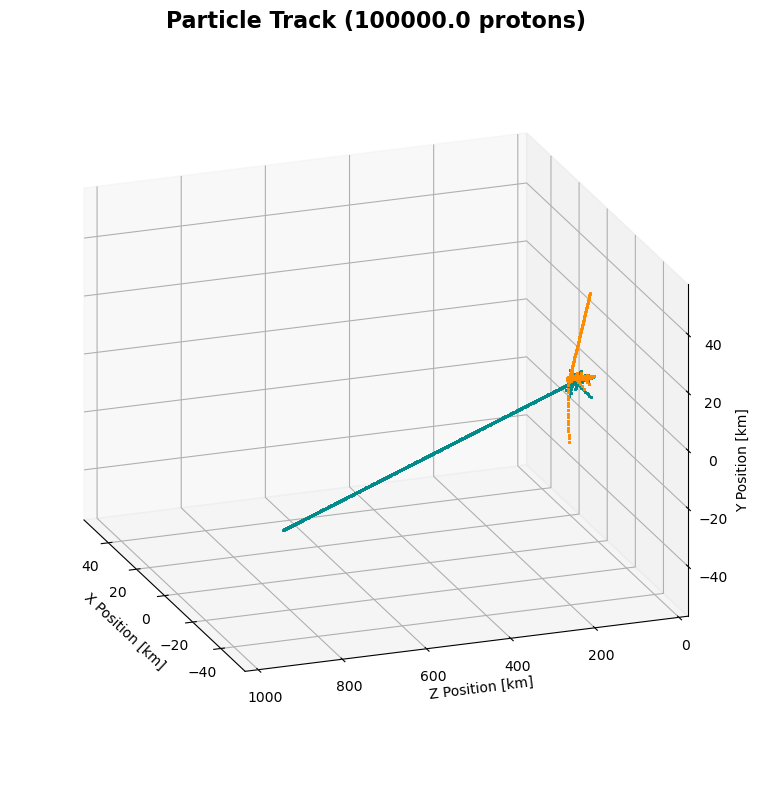

0

In [12]:
##################################################
# Trajectory Plotting (2D)

def plot_trajectory_projections(data, particleTypes, datastr, initial_particle_count, xrange=[-(xWorld+5), (xWorld+5)], yrange=[-(yWorld+5), (yWorld+5)], zrange=[2*zWorld, 0]):

    xmin, xmax = xrange
    ymin, ymax = yrange
    zmin, zmax = zrange

    if (np.abs(xmin) == np.abs(xmax)) and (np.abs(ymin) == np.abs(ymax)) and (np.abs(zmin) == np.abs(zmax)):
        aspect = "equal"
    else:
        aspect = "auto"

    fig, ax = plt.subplots(1, 3, num=1, figsize=(18, 7))
    fig.suptitle("Particle Track ("+str(initial_particle_count)+" protons)", fontsize=16, weight="bold")

    particleColors = []
    for i in range(len(particleTypes)):
        if particleTypes[i] == "proton":
            particleColors.append(protonColor)
        elif particleTypes[i] == "alpha":
            particleColors.append(alphaColor)
        elif particleTypes[i] == "He3":
            particleColors.append(He3Color)
        else:
            particleColors.append("C"+str(i))

    for particleType, particleColor in zip(particleTypes, particleColors):
        ax[0].plot(data[particleType]["posX"], data[particleType]["posY"], "o", markersize=1, label=particleType, color=particleColor)
        ax[1].plot(data[particleType]["posZ"], data[particleType]["posX"], "o", markersize=1, label=particleType, color=particleColor)
        ax[2].plot(data[particleType]["posZ"], data[particleType]["posY"], "o", markersize=1, label=particleType, color=particleColor)
    
    legend = [None, None, None]

    ax[0].set_xlabel("X Position [km]")
    ax[0].set_ylabel("Y Position [km]")
    ax[0].set_title("XY-Plane")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_aspect(aspect)
    legend[0] = ax[0].legend(loc="upper right")
    ax[0].grid()

    ax[1].set_xlabel("Z Position [km]")
    ax[1].set_ylabel("X Position [km]")
    ax[1].set_title("ZX-Plane")
    ax[1].set_xlim(zmin, zmax)
    ax[1].set_ylim(xmin, xmax)
    ax[1].set_aspect(aspect)
    legend[1] = ax[1].legend(loc="upper right")
    ax[1].grid()

    ax[2].set_xlabel("Z Position [km]")
    ax[2].set_ylabel("Y Position [km]")
    ax[2].set_title("ZY-Plane")
    ax[2].set_xlim(zmin, zmax)
    ax[2].set_ylim(ymin, ymax)
    ax[2].set_aspect(aspect)
    legend[2] = ax[2].legend(loc="upper right")
    ax[2].grid()

    for i in range(3):
        for handle in legend[i].legendHandles:
            if isinstance(handle, matplotlib.lines.Line2D):
                handle.set_markersize(10.0)

    plt.tight_layout()
    plt.savefig(plot_dir+"/"+datastr+"_trajectoryProjections.png", dpi=150)
    plt.show()

    return 0

##################################################
# Trajectory Plotting (3D)

def plot_trajectory3D(data, particleTypes, datastr, initial_particle_count, xrange=[-(xWorld+5), (xWorld+5)], yrange=[-(yWorld+5), (yWorld+5)], zrange=[2*zWorld, 0]):

    xmin, xmax = xrange
    ymin, ymax = yrange
    zmin, zmax = zrange

    fig = plt.figure(num=2, figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
    fig.suptitle("Particle Track ("+str(initial_particle_count)+" protons)", fontsize=16, weight="bold")

    particleColors = []
    for particleType in particleTypes:
        if particleType == "proton":
            particleColors.append(protonColor)
        elif particleType == "alpha":
            particleColors.append(alphaColor)
        elif particleType == "He3":
            particleColors.append(He3Color)
        else:
            particleColors.append("black")

    for particleType, particleColor in zip(particleTypes, particleColors):
        ax.plot(data[particleType]["posX"], data[particleType]["posZ"], data[particleType]["posY"], "o", markersize=1, alpha=0.5, label=particleType, color=particleColor)
    ax.view_init(elev=20, azim=-20)
    ax.set_xlabel("X Position [km]")
    ax.set_ylabel("Z Position [km]")
    ax.set_zlabel("Y Position [km]")
    ax.set_xlim(xmax, xmin)
    ax.set_ylim(zmin, zmax)
    ax.set_zlim(ymin, ymax)
    ax.set_aspect("auto")
    ax.grid()

    plt.tight_layout()
    plt.savefig(plot_dir+"/"+datastr+"_trajectory3D.png", dpi=150)
    plt.show()

    return 0

##################################################
# Plotting the Trajectories

plot_trajectory_projections(data, ["proton"], "protonRaw", initial_particle_count)
plot_trajectory_projections(data, ["He3", "alpha"], "heliumRaw", initial_particle_count)
plot_trajectory_projections(gen_data, ["proton"], "protonGen", initial_particle_count)
plot_trajectory_projections(gen_data, ["He3", "alpha"], "heliumGen", initial_particle_count)

plot_trajectory3D(data, ["proton"], "protonRaw", initial_particle_count)
plot_trajectory3D(data, ["He3", "alpha"], "heliumRaw", initial_particle_count)
plot_trajectory3D(gen_data, ["proton"], "protonGen", initial_particle_count)
plot_trajectory3D(gen_data, ["He3", "alpha"], "heliumGen", initial_particle_count)


---
## Particle Position Histograms
---

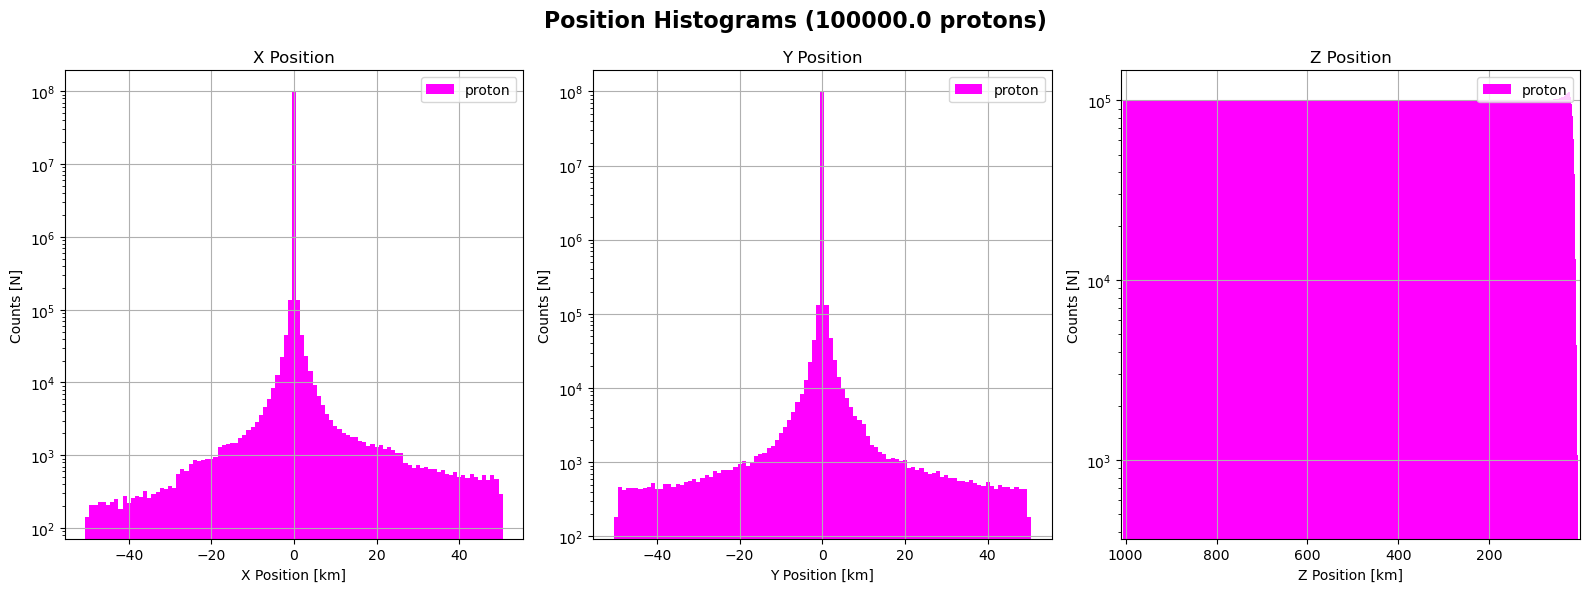

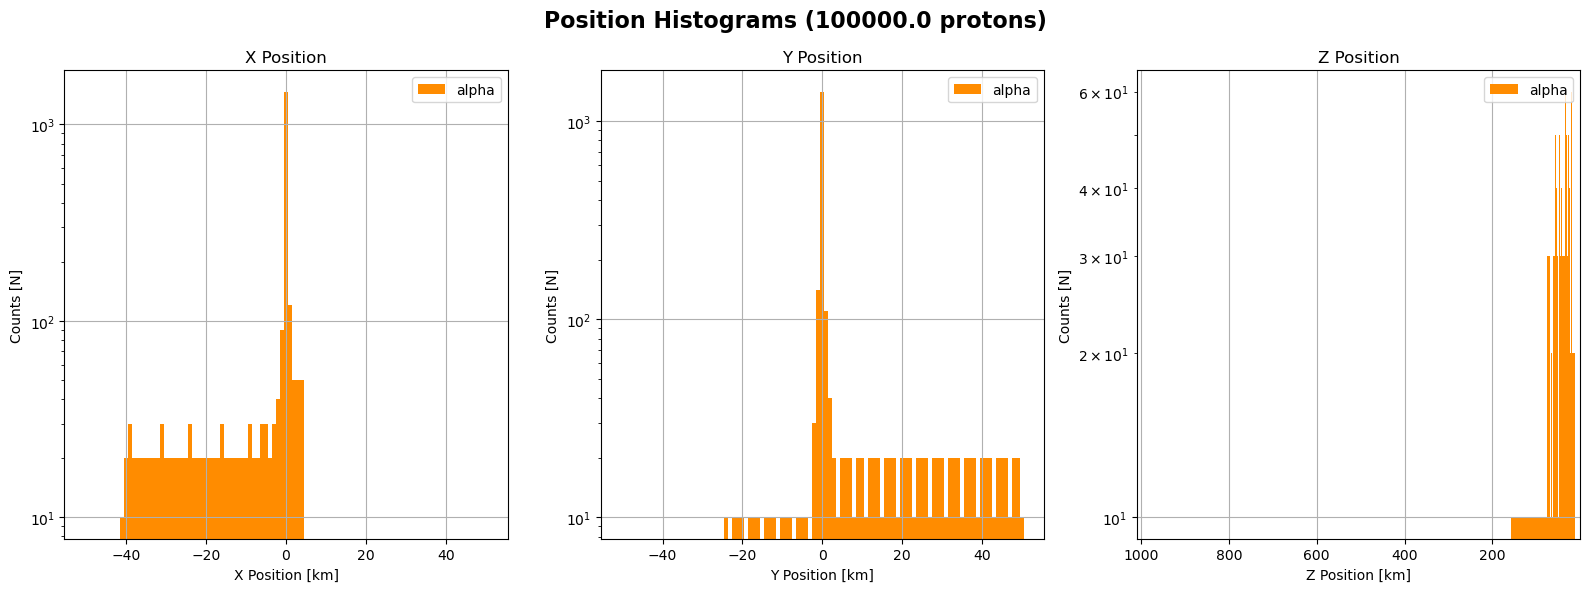

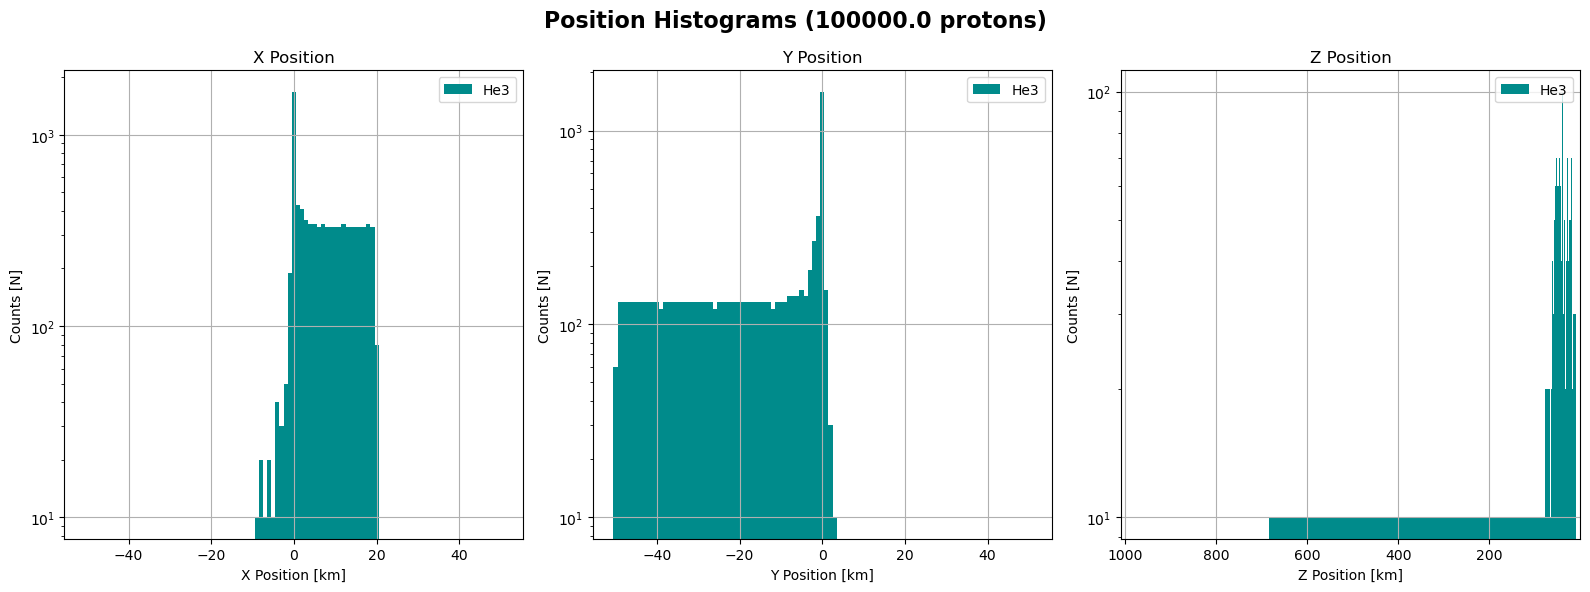

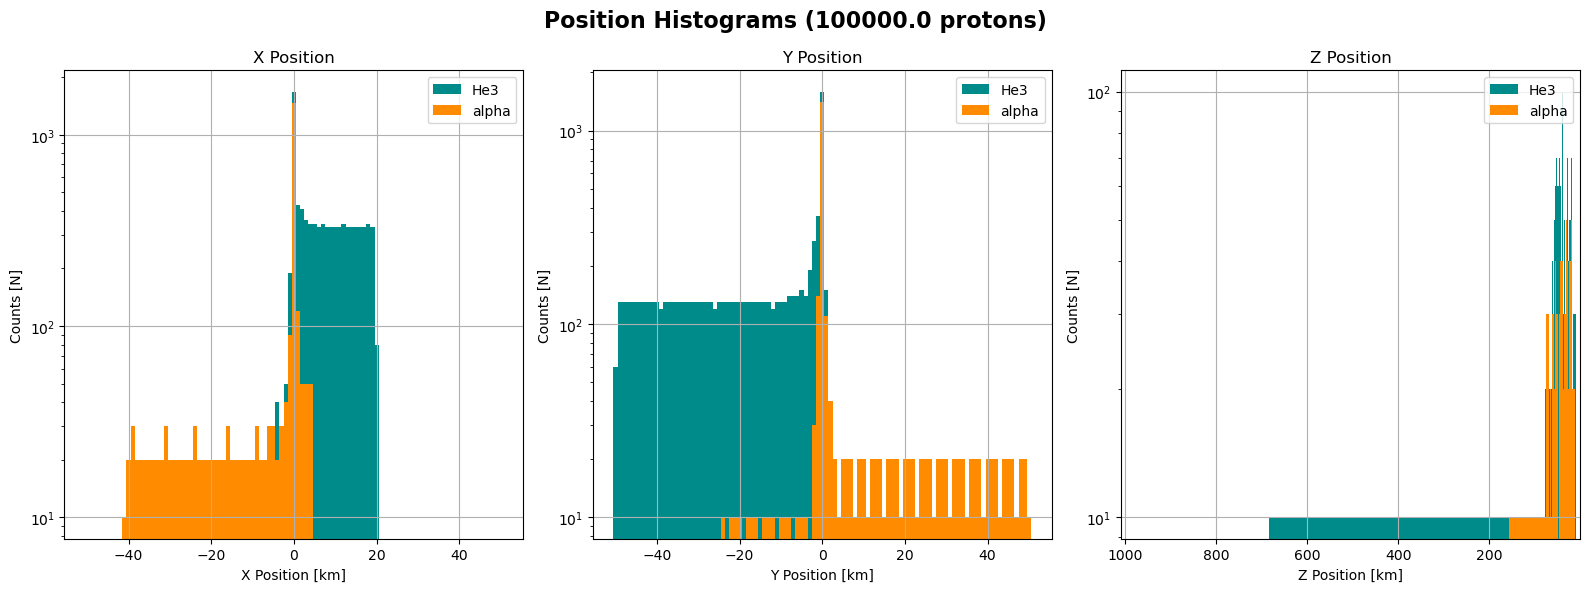

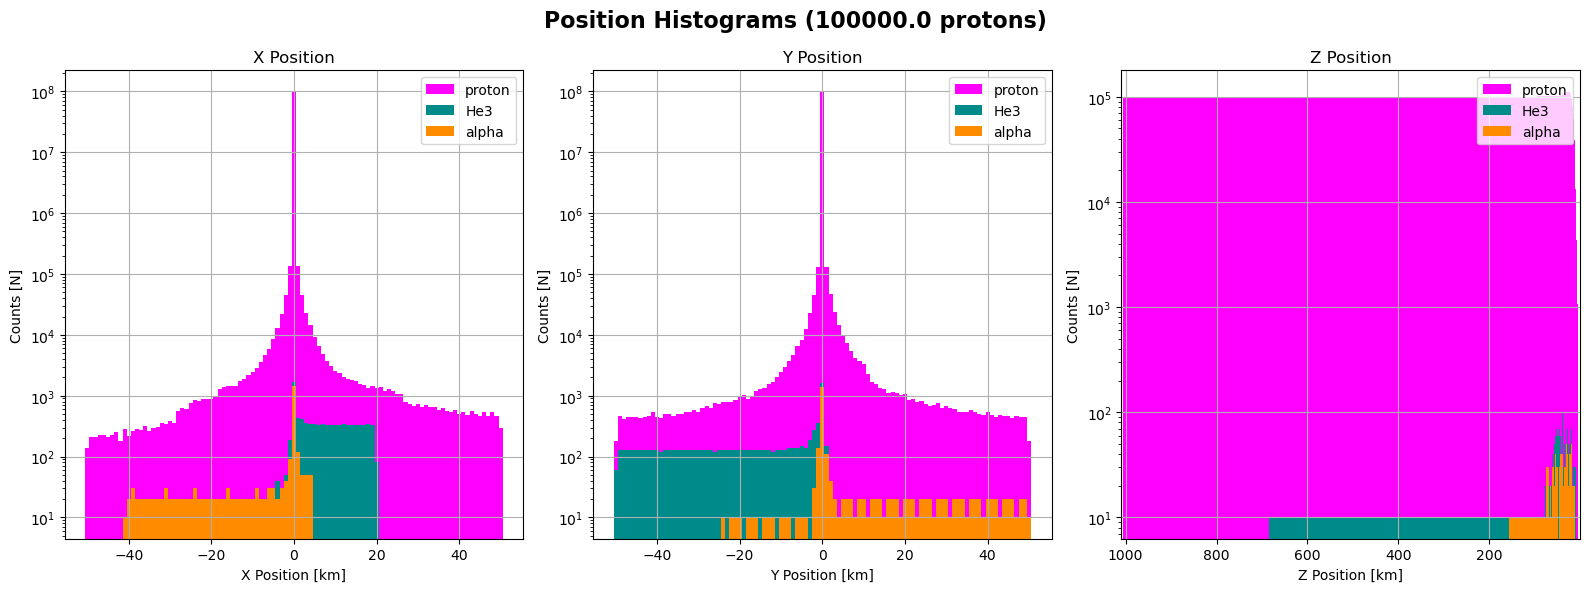

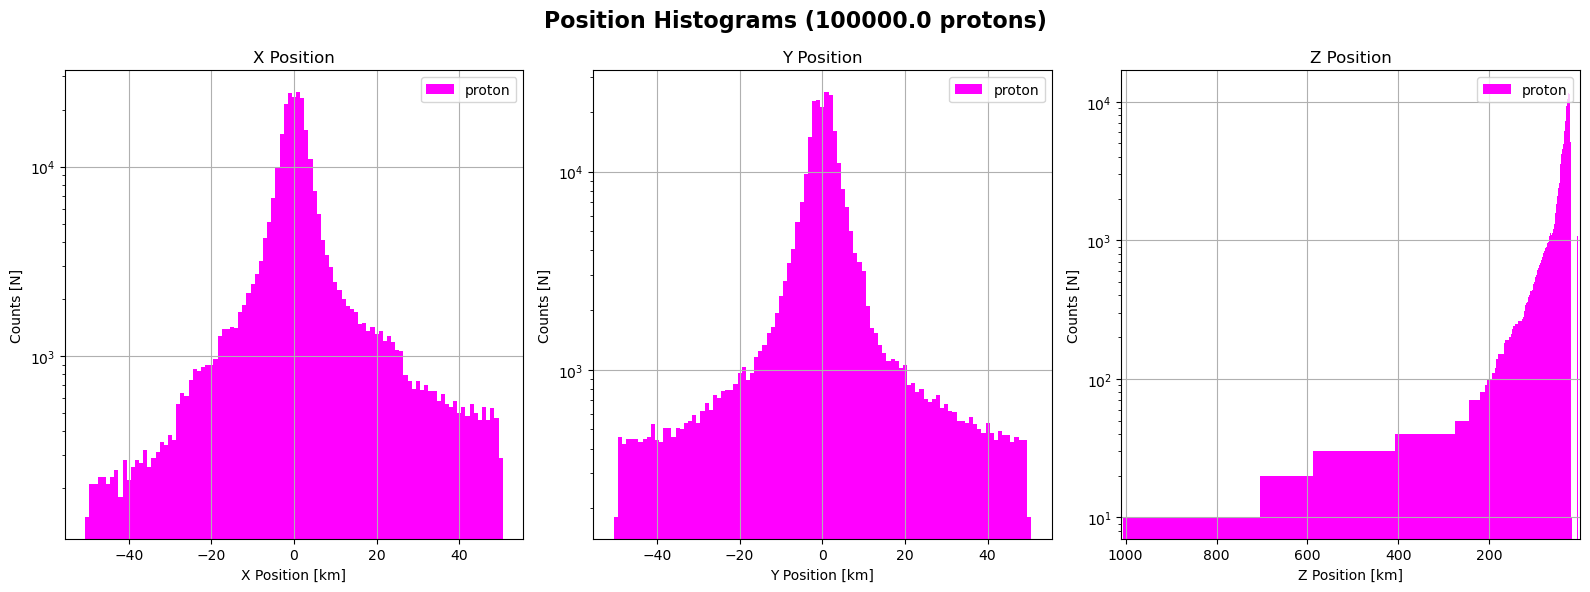

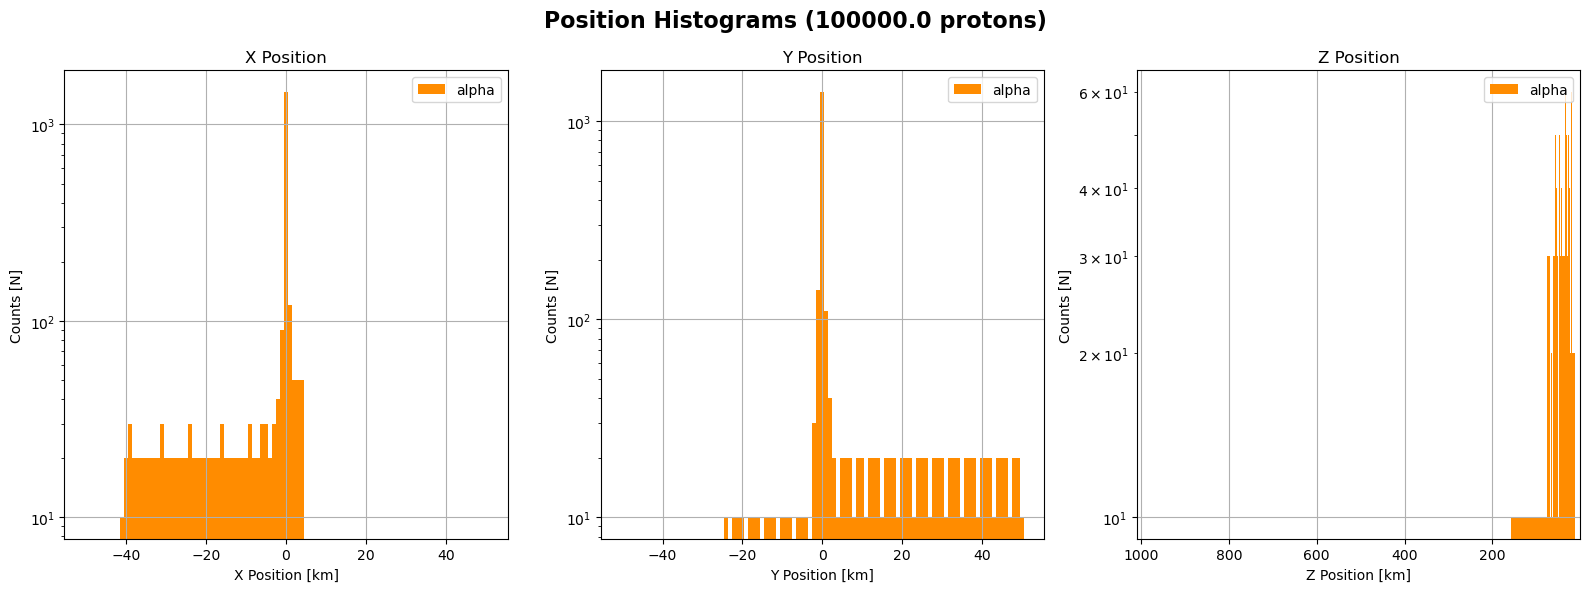

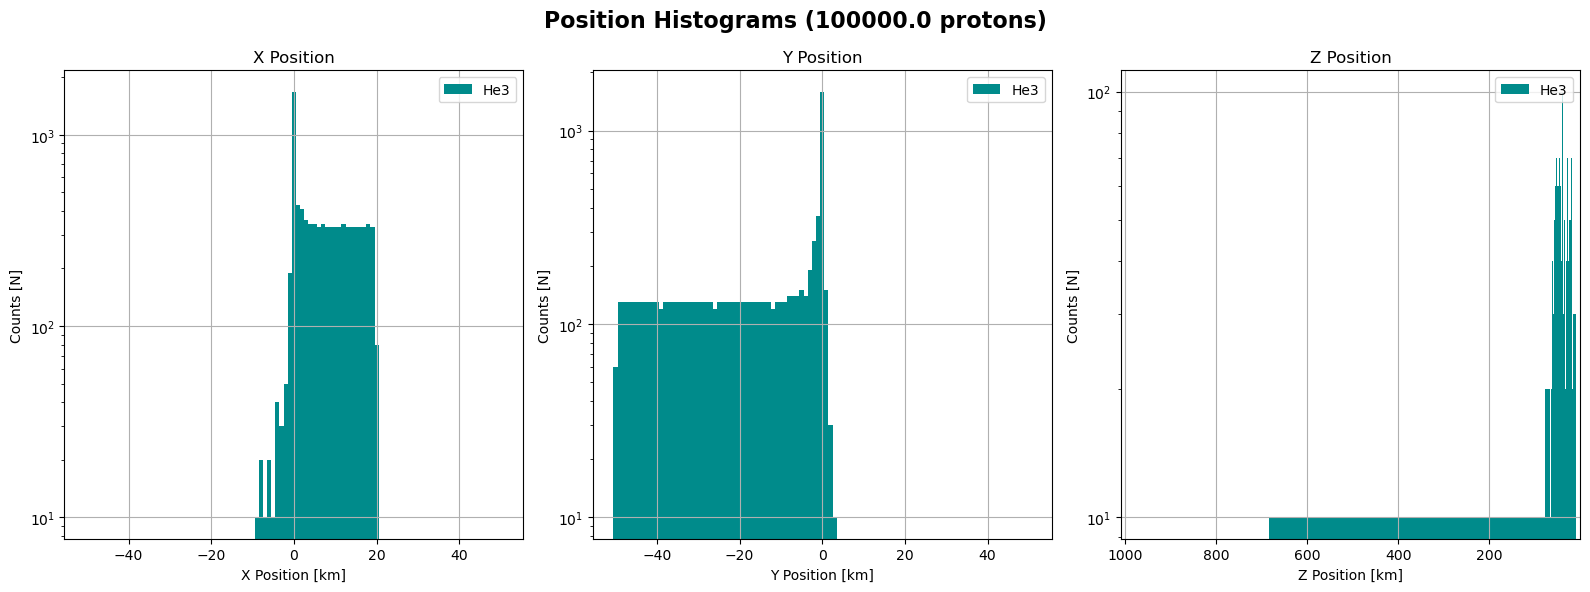

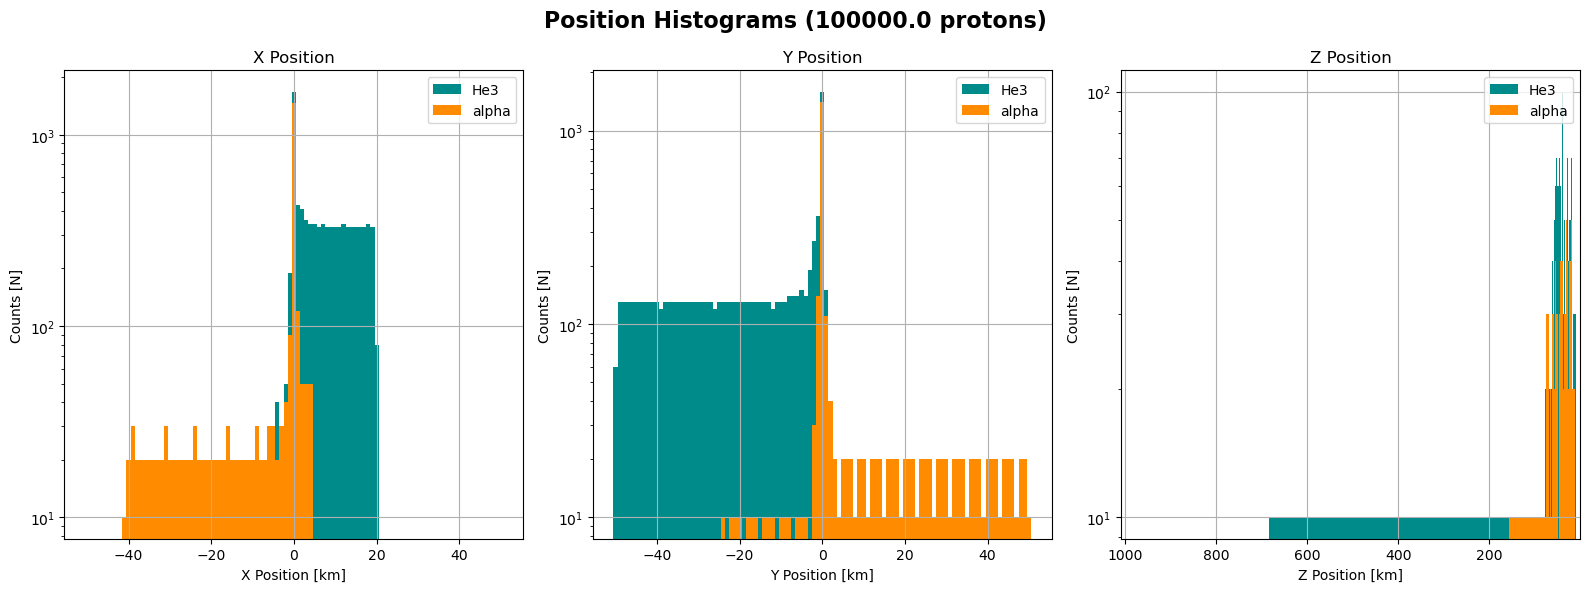

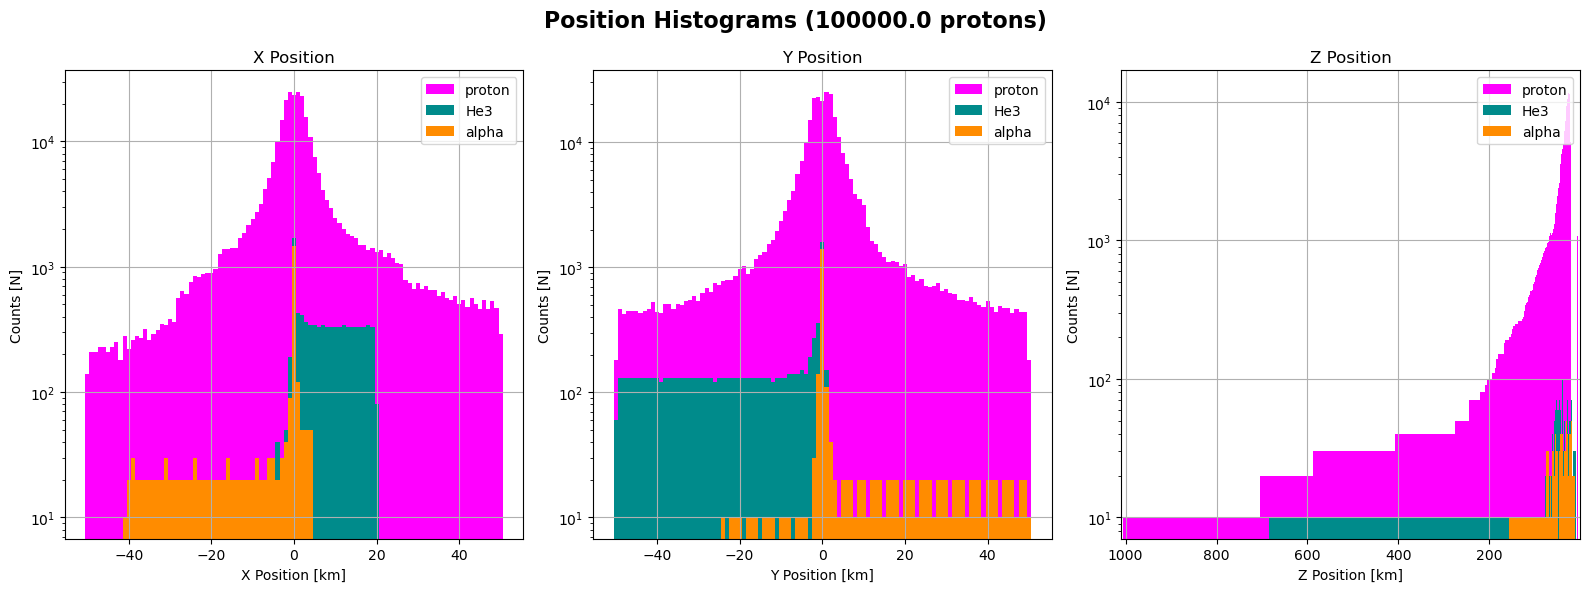

0

In [18]:
##################################################
# Position Histograms

def plt_position_histograms(data, particleTypes, datastr, initial_particle_count, xrange=[-(xWorld+5), (xWorld+5)], yrange=[-(yWorld+5), (yWorld+5)], zrange=[2*zWorld, 0]):
    
    earth_radius = 6378.14 # km
    
    xmin, xmax = xrange
    ymin, ymax = yrange
    zmin, zmax = zrange

    nBinsX = int(np.abs(xmax-xmin))+1
    nBinsY = int(np.abs(ymax-ymin))+1
    nBinsZ = int(np.abs(zmax-zmin))+1

    fig, ax = plt.subplots(1, 3, num=1, figsize=(16, 6))
    fig.suptitle("Position Histograms ("+str(initial_particle_count)+" protons)", fontsize=16, weight="bold")

    particleColors = []
    for i in range(len(particleTypes)):
        if particleTypes[i] == "proton":
            particleColors.append(protonColor)
        elif particleTypes[i] == "alpha":
            particleColors.append(alphaColor)
        elif particleTypes[i] == "He3":
            particleColors.append(He3Color)
        else:
            particleColors.append("C"+str(i))

        ax[0].hist(data[particleTypes[i]]["posX"], bins=nBinsX, range=(xmin-0.5, xmax+0.5), label=particleTypes[i], color=particleColors[i])
        ax[1].hist(data[particleTypes[i]]["posY"], bins=nBinsY, range=(ymin-0.5, ymax+0.5), label=particleTypes[i], color=particleColors[i])
        ax[2].hist(data[particleTypes[i]]["posZ"], bins=nBinsZ, range=(zmax-0.5, zmin+0.5), label=particleTypes[i], color=particleColors[i])

        # if particleTypes[i] == 'proton':
        # ax[0].set_ylim(initial_particle_count-1)
        ax[0].set_yscale("log")
        ax[1].set_yscale("log")
        ax[2].set_yscale("log")

    ax[0].set_xlabel("X Position [km]")
    ax[0].set_ylabel("Counts [N]")
    ax[0].set_title("X Position")
    ax[0].set_xlim(xmin-0.5, xmax+0.5)
    ax[0].legend(loc="upper right")
    ax[0].grid()

    ax[1].set_xlabel("Y Position [km]")
    ax[1].set_ylabel("Counts [N]")
    ax[1].set_title("Y Position")
    ax[1].set_xlim(ymin-0.5, ymax+0.5)
    ax[1].legend(loc="upper right")
    ax[1].grid()

    ax[2].set_xlabel("Z Position [km]")
    ax[2].set_ylabel("Counts [N]")
    ax[2].set_title("Z Position")
    ax[2].set_xlim(zmin-0.5, zmax+0.5)
    ax[2].legend(loc="upper right")
    ax[2].grid()

    plt.tight_layout()
    plt.savefig(plot_dir+"/"+datastr+"_position_histograms.png", dpi=150)
    plt.show()

    return 0

##################################################
# Plotting the Position Histograms

plt_position_histograms(data, ["proton"], "protonRaw", initial_particle_count)
plt_position_histograms(data, ["alpha"], "alphaRaw", initial_particle_count)
plt_position_histograms(data, ["He3"], "He3Raw", initial_particle_count)
plt_position_histograms(data, ["He3", "alpha"], "heliumRaw", initial_particle_count)
plt_position_histograms(data, ["proton", "He3", "alpha"], "allRaw", initial_particle_count)

plt_position_histograms(gen_data, ["proton"], "protonGen", initial_particle_count)
plt_position_histograms(gen_data, ["alpha"], "alphaGen", initial_particle_count)
plt_position_histograms(gen_data, ["He3"], "He3Gen", initial_particle_count)
plt_position_histograms(gen_data, ["He3", "alpha"], "heliumGen", initial_particle_count)
plt_position_histograms(gen_data, ["proton", "He3", "alpha"], "allGen", initial_particle_count)



---
## Atomic & Mass Number Histograms
---

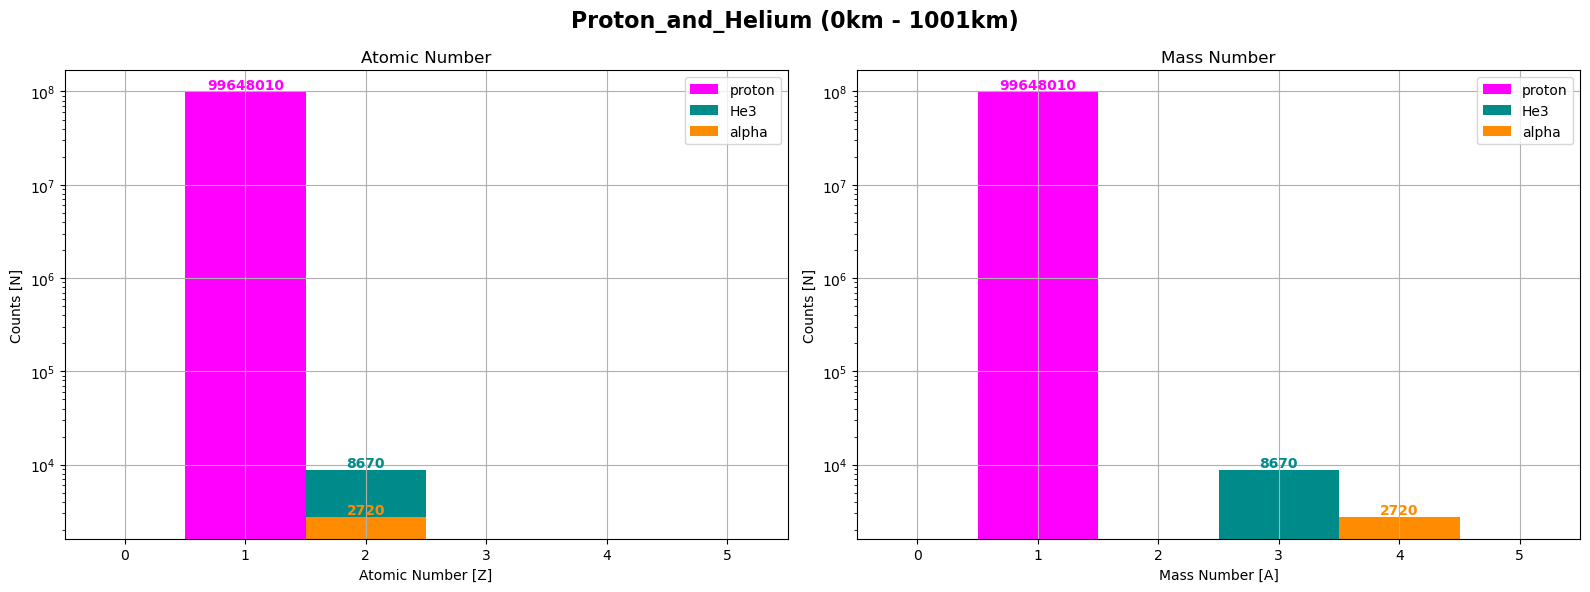

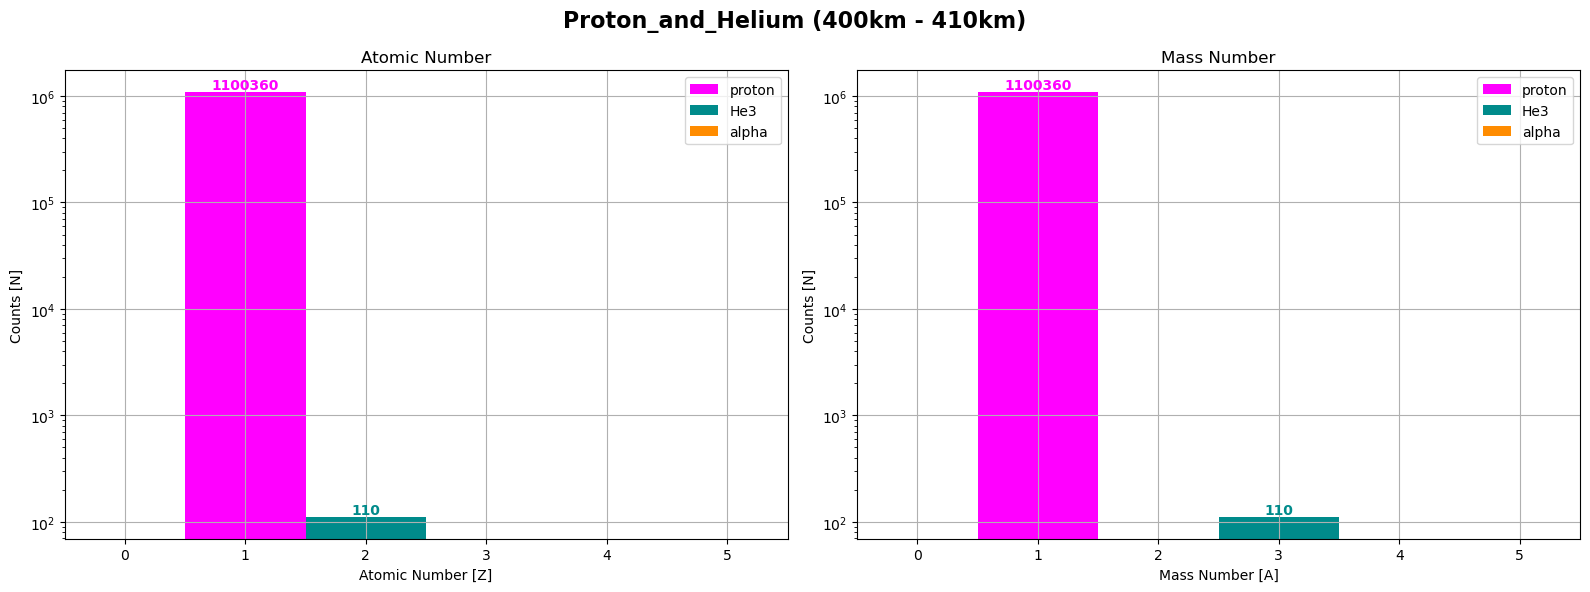

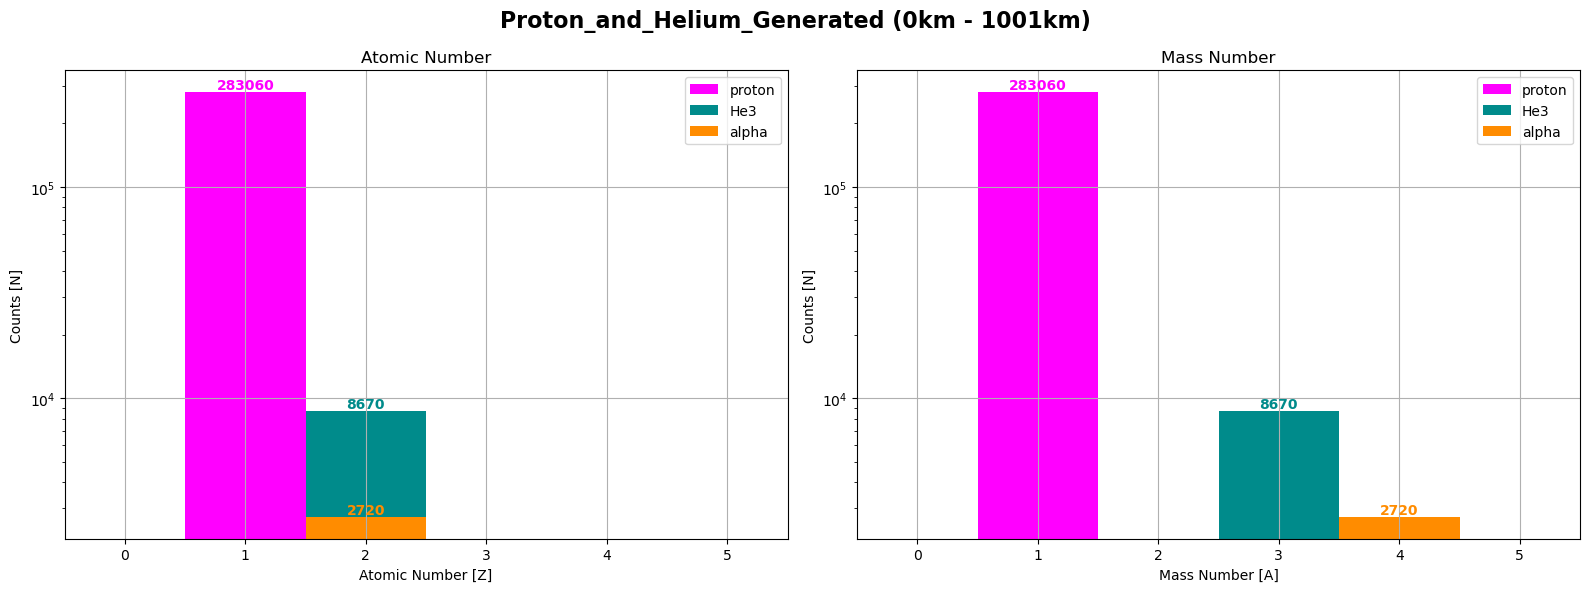

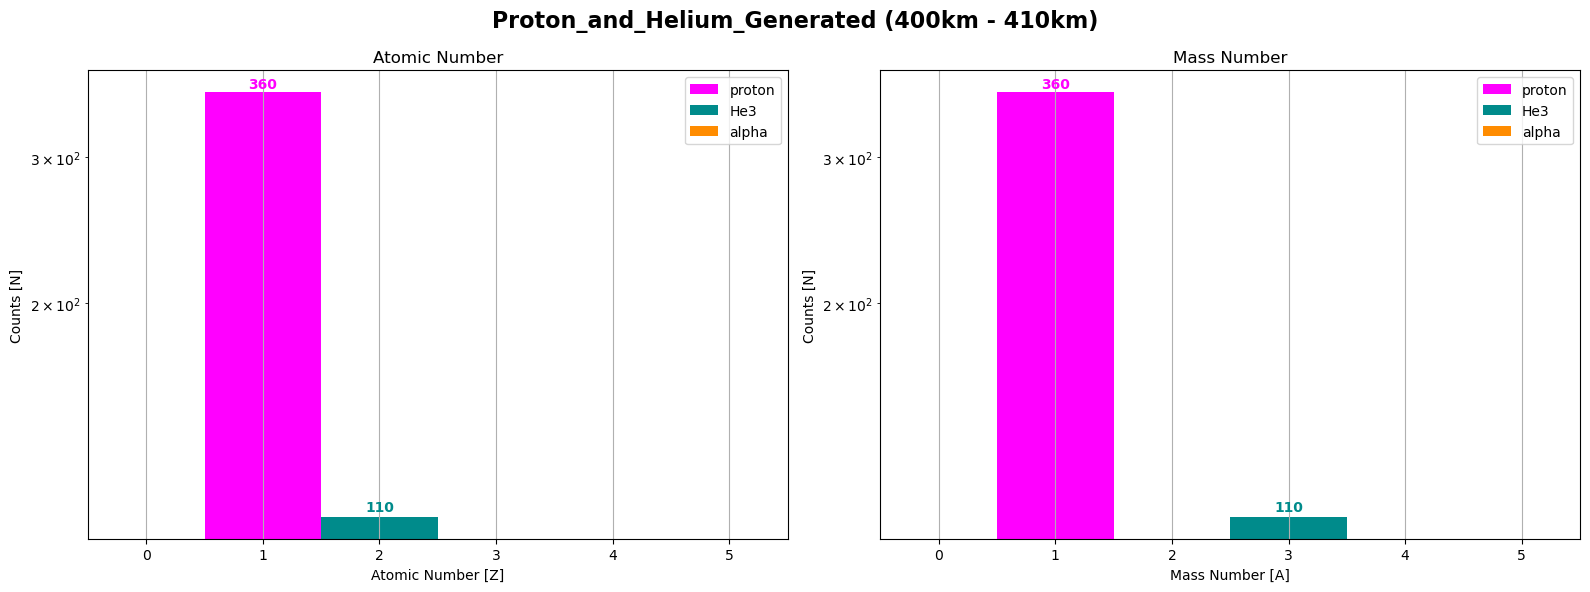

0

In [32]:
##################################################
# Atomic & Mass Number Histograms: 0km - 1001km

def plot_ZA_histograms(data, particleTypes, datastr):

    range_min = -0.5
    range_max = 5.5
    nBins = int(range_max - range_min)

    xtick_min = int(range_min + 0.5)
    xtick_max = int(range_max - 0.5)+1

    fig, ax = plt.subplots(1, 2, num=3, figsize=(16, 6))
    fig.suptitle(datastr+" (0km - 1001km)", fontsize=16, weight="bold")

    particleColors = []
    for i in range(len(particleTypes)):
        if particleTypes[i] == "proton":
            particleColors.append(protonColor)
        elif particleTypes[i] == "alpha":
            particleColors.append(alphaColor)
        elif particleTypes[i] == "He3":
            particleColors.append(He3Color)
        else:
            particleColors.append("C"+str(i))

    for particleType, particleColor in zip(particleTypes, particleColors):
        counts0, edges0, bars0 = ax[0].hist(data[particleType]["atomicNumber"], bins=nBins, \
                                            range=(range_min, range_max), label=particleType, \
                                            color=particleColor, histtype='barstacked')
        counts1, edges1, bars1 = ax[1].hist(data[particleType]["massNumber"], bins=nBins, \
                                            range=(range_min, range_max), label=particleType, \
                                            color=particleColor, histtype='barstacked')

        # Apply labels to each bar individually
        for b0, count0, edge0 in zip(bars0, counts0, edges0[:-1]):
            x0 = edge0 + (edges0[1] - edges0[0]) / 2
            y0 = b0.get_height() + 1
            if b0.get_height() > 0.1:  # Adjust the threshold as needed
                ax[0].text(x0, y0, f'{count0.astype(int)}', weight='bold', color=particleColor, ha='center', va='bottom')

        for b1, count1, edge1 in zip(bars1, counts1, edges1[:-1]):
            x1 = edge1 + (edges1[1] - edges1[0]) / 2
            y1 = b1.get_height() + 1
            if b1.get_height() > 0.1:  # Adjust the threshold as needed
                ax[1].text(x1, y1, f'{count1.astype(int)}', weight='bold', color=particleColor, ha='center', va='bottom')

    ax[0].set_title("Atomic Number")
    ax[0].set_xlabel("Atomic Number [Z]")
    ax[0].set_ylabel("Counts [N]")
    ax[0].set_xlim(range_min, range_max)
    # ax[0].set_ylim(1, 1e7)
    ax[0].set_xticks(np.arange(xtick_min, xtick_max, 1))
    ax[0].set_yscale("log")
    ax[0].legend()
    ax[0].grid()

    ax[1].set_title("Mass Number")
    ax[1].set_xlabel("Mass Number [A]")
    ax[1].set_ylabel("Counts [N]")
    ax[1].set_xlim(range_min, range_max)
    # ax[1].set_ylim(1, 1e7)
    ax[1].set_xticks(np.arange(xtick_min, xtick_max, 1))
    ax[1].set_yscale("log")
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.savefig(plot_dir+"/"+datastr+"_ZA_histograms.png", dpi=150)
    plt.show()

    return 0

##################################################
# Atomic & Mass Number Histograms: 400km - 410km

def plot_ZA_40km_histograms(data, particleTypes, datastr):

    range_min = -0.5
    range_max = 5.5
    nBins = int(range_max - range_min)

    xtick_min = int(range_min + 0.5)
    xtick_max = int(range_max - 0.5)+1

    fig, ax = plt.subplots(1, 2, num=3, figsize=(16, 6))
    fig.suptitle(datastr+" (400km - 410km)", fontsize=16, weight="bold")

    particleColors = []
    for i in range(len(particleTypes)):
        if particleTypes[i] == "proton":
            particleColors.append(protonColor)
        elif particleTypes[i] == "alpha":
            particleColors.append(alphaColor)
        elif particleTypes[i] == "He3":
            particleColors.append(He3Color)
        else:
            particleColors.append("C"+str(i))

    for particleType, particleColor in zip(particleTypes, particleColors):

        layer_mask = (data[particleType]["layerNumber"] >= 400) & (data[particleType]["layerNumber"] <= 410)

        counts0, edges0, bars0 = ax[0].hist(data[particleType]["atomicNumber"][layer_mask], bins=nBins, \
                                            range=(range_min, range_max), label=particleType, \
                                            color=particleColor, histtype='barstacked')
        counts1, edges1, bars1 = ax[1].hist(data[particleType]["massNumber"][layer_mask], bins=nBins, \
                                            range=(range_min, range_max), label=particleType, \
                                            color=particleColor, histtype='barstacked')

        # Apply labels to each bar individually
        for b0, count0, edge0 in zip(bars0, counts0, edges0[:-1]):
            x0 = edge0 + (edges0[1] - edges0[0]) / 2
            y0 = b0.get_height() + 1
            if b0.get_height() > 0.1:  # Adjust the threshold as needed
                ax[0].text(x0, y0, f'{count0.astype(int)}', weight='bold', color=particleColor, ha='center', va='bottom')

        for b1, count1, edge1 in zip(bars1, counts1, edges1[:-1]):
            x1 = edge1 + (edges1[1] - edges1[0]) / 2
            y1 = b1.get_height() + 1
            if b1.get_height() > 0.1:  # Adjust the threshold as needed
                ax[1].text(x1, y1, f'{count1.astype(int)}', weight='bold', color=particleColor, ha='center', va='bottom')


    ax[0].set_title("Atomic Number")
    ax[0].set_xlabel("Atomic Number [Z]")
    ax[0].set_ylabel("Counts [N]")
    ax[0].set_xlim(range_min, range_max)
    # ax[0].set_ylim(1, 1e5)
    ax[0].set_xticks(np.arange(xtick_min, xtick_max, 1))
    ax[0].set_yscale("log")
    ax[0].legend()
    ax[0].grid()

    ax[1].set_title("Mass Number")
    ax[1].set_xlabel("Mass Number [A]")
    ax[1].set_ylabel("Counts [N]")
    ax[1].set_xlim(range_min, range_max)
    # ax[1].set_ylim(1, 1e5)
    ax[1].set_xticks(np.arange(xtick_min, xtick_max, 1))
    ax[1].set_yscale("log")
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.savefig(plot_dir+"/"+datastr+"_ZA_histograms.png", dpi=150)
    plt.show()

    return 0

##################################################
# Plot Atomic Number Histograms

plot_ZA_histograms(data, ["proton", "He3", "alpha"], "Proton_and_Helium")
plot_ZA_40km_histograms(data, ["proton", "He3", "alpha"], "Proton_and_Helium")

plot_ZA_histograms(gen_data, ["proton", "He3", "alpha"], "Proton_and_Helium_Generated")
plot_ZA_40km_histograms(gen_data, ["proton", "He3", "alpha"], "Proton_and_Helium_Generated")

